In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
from collections import defaultdict
import cv2
import numpy as np
from ultralytics import FastSAM
import time
from shapely.geometry import Point, Polygon
from numba import njit, prange

In [ ]:
# Object class, containing a tracked object's bounding boxes and masks

# Members:
# parent
# rows, cols
# id
# segBox, x1, x2, y1, y2
# cartBox
# twoDBox
# masksOutline: only here cuz slow
# segMask
# edgeMask
# cartMask

class Object:
    def __init__(self, parent, dimensions, id, box, segMask):
        self.segMask = None # until I speed get_seg_mask up
        self.edgeMask = None
        self.cartMask = None
        self.cartBox = None
        self.twoDBox = None
        self.parent = parent
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        self.id = id
        self.segBox = np.empty([5,2], dtype=int)
        x, y, w, h = box # (x, y) = center point, w = width, h = height
        self.x1 = math.ceil(y - h / 2)
        self.x2 = math.floor(y + h / 2)
        self.y1 = math.ceil(x - w / 2)
        self.y2 = math.floor(x + w / 2)
        self.segBox[0] = [self.y1, self.x1]
        self.segBox[1] = [self.y1, self.x2]
        self.segBox[2] = [self.y2, self.x2]
        self.segBox[3] = [self.y2, self.x1]
        self.segBox[4] = [self.y1, self.x1]
        self.maskOutline = segMask.astype(int)
        self.maskOutline = np.append(self.maskOutline, self.maskOutline[0,:].reshape((1, 2)), axis=0)

    def is_in_scope(self, distance, height):
        if(self.cartMask is None):
            self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)
        for i in range(3):
            maskedCart[:,:,i] = np.where(self.cartMask, maskedCart[:,:,i], np.nan)
        if np.nanmax(maskedCart[:,:,2]) > distance or np.nanmin(maskedCart[:,:,1]) > height:
            return False
        if np.nanstd(maskedCart[:,:,1]) < .01: # filters objects consisting of the street
            return False
        return True

    def get_seg_box(self):
        return self.segBox

    def get_cart_box(self):
        if self.cartBox is not None:
            return self.cartBox
        self.get_cart_mask()
        maxX = maxY = 0
        minX = self.rows
        minY = self.cols
        for x in range(self.rows):
            for y in range(self.cols):
                if self.cartMask[x,y]:
                    maxX = max(maxX, x)
                    minX = min(minX, x)
                    maxY = max(maxY, y)
                    minY = min(minY, y)
        box = np.zeros([5,2])
        box[0] = [minY, minX]
        box[1] = [maxY, minX]
        box[2] = [maxY, maxX]
        box[3] = [minY, maxX]
        box[4] = [minY, minX]
        self.cartBox = box
        return self.cartBox
    
    def get_twoD_box(self):
        if(self.twoDBox is not None):
            return self.twoDBox
        self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)
        for i in range(3):
            maskedCart[:,:,i] = np.where(self.cartMask, maskedCart[:,:,i], np.nan)
        box = np.zeros([5,2])
        box[0] = [np.nanmin(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        box[1] = [np.nanmax(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        box[2] = [np.nanmax(maskedCart[:,:,0]), np.nanmin(maskedCart[:,:,2])]
        box[3] = [np.nanmin(maskedCart[:,:,0]), np.nanmin(maskedCart[:,:,2])]
        box[4] = [np.nanmin(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        self.twoDBox = box
        return self.twoDBox

    def get_seg_mask(self): # should do this durring init, but its suuuuper slow to do so rn
        if(self.segMask is not None):
            return self.segMask
        self.segMask = np.zeros([self.rows, self.cols]).astype(bool)
        polygon = Polygon(self.maskOutline)
        for x in range(self.x1,self.x2):
            for y in range(self.y1,self.y2):
                point = Point([y,x])
                if(point.within(polygon)):
                    self.segMask[x,y] = 1
        return self.segMask
    
    def bins_for_mask(self, num_bins, img, box=None):
        if(box is None):
            x1 = y1 = 0
            x2 = img.shape[0]
            y2 = img.shape[1]
        else:
            x1, x2, y1, y2 = self.x1, self.x2, self.y1, self.y2
        area = int((x2 - x1) * (y2 - y1))
        counters = np.zeros([num_bins]).astype(int)
        bins = np.empty([num_bins,area,2])
        mini = np.nanmin(img)
        maxi = np.nanmax(img)
        diff = (maxi - mini) / (num_bins)
        for x in range(x1,x2):
            for y in range(y1,y2):
                p = img[x,y]
                if np.isnan(p):
                    continue
                bound = mini
                for i in range(num_bins):
                    if(bound < p and p < bound + diff):
                        bins[i,counters[i],:] = [x,y]
                        counters[i] = counters[i] + 1
                    bound = bound + diff
        mask = np.zeros([img.shape[0], img.shape[1]]).astype(bool)
        idx = np.where(counters == np.max(counters))[0][0]
        num_p = counters[idx]
        bin = bins[idx,0:num_p,:].astype(int) # should add logic to account for the wanted points being split by a bin boundary
        for i in range(num_p):
            x, y = bin[i,:]
            mask[x, y] = True
        return mask
    
    def get_edge_mask(self): # should also be done in init
        if(self.edgeMask is not None):
            return self.edgeMask
        self.get_seg_mask()
        edge_number_bins = 10 # constant to be messed with
        edge_img = np.copy(self.parent.edgeImg)
        edge_img = np.where(self.segMask, edge_img, np.nan)
        self.edgeMask = self.bins_for_mask(edge_number_bins, edge_img, self.segBox)
        return self.edgeMask
        
    def get_cart_mask(self): # should also be done in init
        if(self.cartMask is not None):
            return self.cartMask
        self.get_edge_mask()
        cart_number_bins = 4 # constant to be messed with
        cart_img = np.copy(self.parent.cartImg[:,:,2])
        cart_img = np.where(self.edgeMask, cart_img, np.nan)
        cartMask = self.bins_for_mask(cart_number_bins, cart_img, self.segBox)
        cart_post_bin = np.where(cartMask, cart_img, np.nan)
        mean = np.nanmean(cart_post_bin)
        std = np.nanstd(cart_post_bin)
        self.cartMask = np.where(np.logical_and(cart_post_bin > mean - std, \
                                               cart_post_bin < mean + std), cartMask, False)
        return self.cartMask

In [3]:
# Frame class, containing an rgb+d image and its tracked objects

# Members:
# parent
# frame_idx
# rows, cols
# rgbImg
# depthImg
# cartImg
# edgeImg
# objects
# ids
# idToIdx
# scope_distance
# safe_height

class Frame:
    def __init__(self, parent, frame_idx, dimensions, rgbImg, depthImg, results, horiz_fov, scope_distance, safe_height):
        self.parent = parent
        self.frame_idx = frame_idx
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        horiz_fov = horiz_fov * math.pi / 180
        vert_fov = self.rows * horiz_fov / self.cols
        self.rgbImg = rgbImg
        self.depthImg = depthImg
        self.scope_distance = scope_distance
        self.safe_height = safe_height
        # self.depthImgClipped = np.clip(self.depthImg, 0, 12) # OAK-D can only infer up to 12m away
        self.objects = []
        self.ids = np.array(results.boxes.id.int().cpu().tolist())
        self.idToIdx = {}
        boxes = results.boxes.xywh.cpu()
        masks = results.masks.xy
        for idx, (id, box, mask) in enumerate(zip(self.ids, boxes, masks)):
            if mask.shape[0] > 2:
                self.idToIdx[id] = idx
                obj = Object(self, dimensions, id, box, mask)
                self.objects.append(obj)

        depth_sphe = np.empty([self.rows, self.cols, 3]) # theta = left/right, phi = up/down, rho = distance        
        depth_cart = np.empty([self.rows, self.cols, 3]) # x = left/right, y = up/down, z = in/out
        depth_sphe[:,:,0] = np.linspace(-horiz_fov / 2, horiz_fov / 2, num = self.cols)
        depth_sphe[:,:,1] = np.linspace(-vert_fov / 2, vert_fov / 2, num = self.rows)[np.newaxis].T
        depth_sphe[:,:,2] = self.depthImg

        def sphe_to_cart(sphe):
            theta = sphe[0]
            phi = sphe[1]
            rho = sphe[2]
            x = rho * math.sin(theta)
            y = rho * math.sin(phi)
            z = rho
            return [x, -y, z]

        for i in range(self.rows):
            for j in range(self.cols):
                depth_cart[i,j,:] = sphe_to_cart(depth_sphe[i,j,:])
        self.cartImg = np.copy(depth_cart)
        
        depth_cart[:,:,2] = np.where(depth_cart[:,:,2] < 500, depth_cart[:,:,2], 0)
        for i in range(3):
            depth_cart[:,:,i] = depth_cart[:,:,i] - np.min(depth_cart[:,:,i])
            depth_cart[:,:,i] = depth_cart[:,:,i] / np.max(depth_cart[:,:,i])
        grayImage = depth_cart[:,:,2].astype('float64')
        self.edgeImg = cv2.Sobel(src=grayImage, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis

    def visualize_objects(self):
        plt.figure("rgb")
        plt.imshow(self.rgbImg)
        plt.figure("2D")
        plt.scatter(0,0) # camera coordinates
        # plt.figure("mask")
        # plt.imshow(window.get_frame(0).rgbImg)
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(self.parent.number_objects()):
            obj = self.parent.get_object(self.frame_idx,i)
            if obj.is_in_scope(self.scope_distance, self.safe_height):
                plt.figure("rgb")
                cartBox = obj.get_cart_box()
                plt.plot(cartBox[:,0], cartBox[:,1], colors[i % 10])
                plt.figure("2D")
                twoDBox = obj.get_twoD_box()
                plt.fill(twoDBox[:,0], twoDBox[:,1], colors[i % 10])

In [4]:
# Window class, containing frames and tracking common objects

# Members:
# model
# frames
# rows, cols
# trackedObjects
# idxToId

class Window:
    def __init__(self, imgName, startingNumber, numberImages, horiz_fov, scope_distance, safe_height):
        self.model = FastSAM("FastSAM-s.pt")  # or FastSAM-x.pt #model = YOLO("yolo11n.pt")
        self.frames = []
        for frame_idx in range(numberImages):
            rgbImg = np.asarray(Image.open("../demo_data/rgb" + imgName + str(startingNumber + frame_idx) + ".jpeg"))
            depthImg = np.loadtxt("../demo_data/depth" + imgName + str(startingNumber + frame_idx) + ".out", delimiter=",")
            dimensions = np.array(rgbImg.shape)
            self.rows = dimensions[0]
            self.cols = dimensions[1]
            results = self.model.track(rgbImg, persist=True)[0]
            frame = Frame(self, frame_idx, [self.rows, self.cols], rgbImg, depthImg, results, horiz_fov, scope_distance, safe_height)
            self.frames.append(frame)
        self.trackedObjects = self.frames[0].ids
        for i, frame in enumerate(self.frames):
            if(i == 0):
                pass
            self.trackedObjects = np.intersect1d(self.trackedObjects, frame.ids)
        self.idxToId = {}
        for idx, obj in enumerate(self.trackedObjects):
            self.idxToId[idx] = obj

    def number_objects(self):
        return len(self.trackedObjects)

    def get_frame(self, frame_idx):
        return self.frames[frame_idx]

    def get_object(self, frame_idx, obj_idx):
        frame = self.get_frame(frame_idx)
        idx = frame.idToIdx[self.idxToId[obj_idx]]
        return frame.objects[idx]

    def get_masked_img(self, frame_idx, obj_idx, img_name = 'cart', mask_name = 'cart'):
        frame  = self.get_frame(frame_idx)
        obj = self.get_object(frame_idx, obj_idx)
        if mask_name == 'seg':
            mask = obj.get_seg_mask()
        elif mask_name == 'edge':
            mask = obj.get_edge_mask()
        else:
            mask = obj.get_cart_mask()
        if img_name == 'rgb':
            img = np.copy(frame.rgbImg)
            for i in range(3):
                img[:,:,i] = np.where(mask, img[:,:,i], np.nan)
        elif img_name == 'd':
            img = np.copy(frame.depthImg)
            img = np.ma.array(img, mask=~mask)
        else:
            img = np.copy(frame.cartImg)
            for i in range(3):
                img[:,:,i] = np.where(mask, img[:,:,i], np.nan)
        return img

In [5]:
# Initialization
# Note: The dataset currently has a slight temporal offset between the rgb and depth images, leading to artifacts

imgName = '1080p'
startingNumber = 60
numberImages = 2
horiz_fov = 72
scope_distance = 20
safe_height = 2

window = Window(imgName, startingNumber, numberImages, horiz_fov, scope_distance, safe_height)

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


0: 384x640 107 objects, 109.2ms
Speed: 4.9ms preprocess, 109.2ms inference, 39.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 40 objects, 61.2ms
Speed: 1.8ms preprocess, 61.2ms inference, 37.8ms postprocess per image at shape (1, 3, 384, 640)


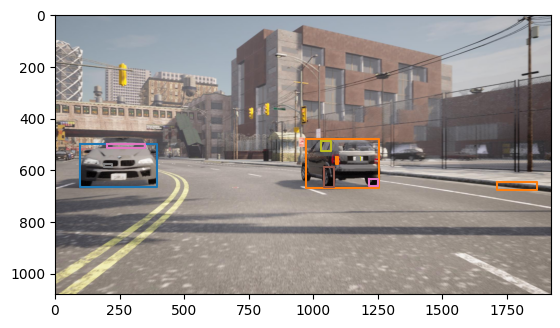

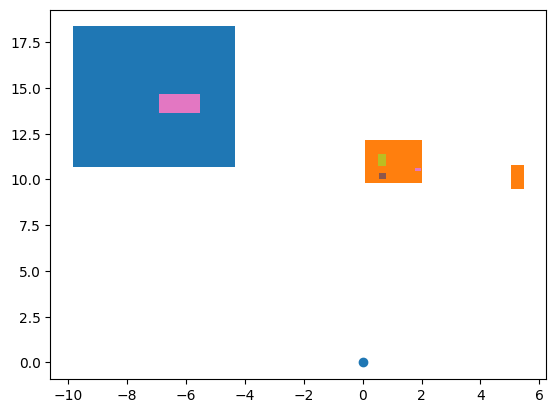

In [6]:
# Nearby objects placed in space where collisions can be detected
# Note: This process takes ~2.5 minutes as code is being run on the CPU alone (aside from FastSAM), GPU utilization to come in near future

frame = window.get_frame(0)
frame.visualize_objects()

/tmp/ipykernel_1104017/3665065937.py:55: RuntimeWarning: invalid value encountered in cast
  img[:,:,i] = np.where(mask, img[:,:,i], np.nan)


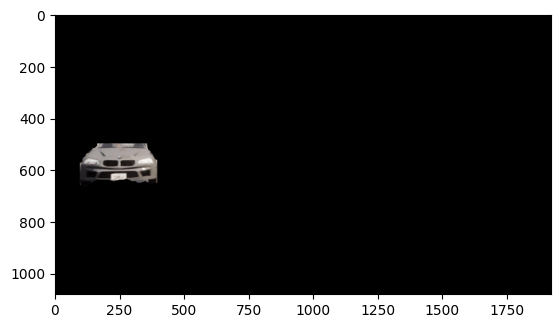

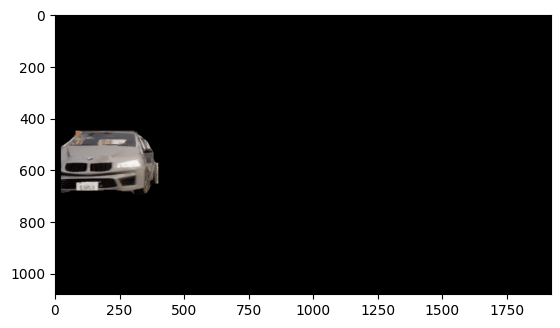

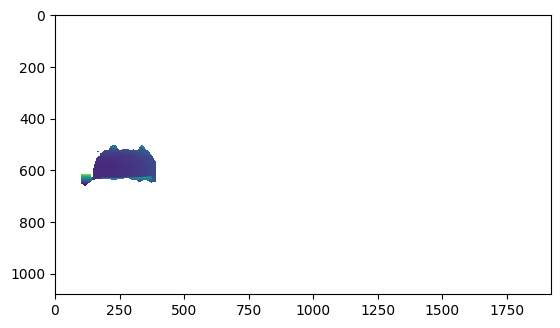

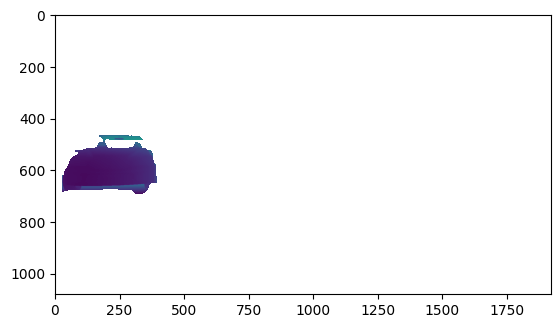

In [7]:
# Object being tracked through time

idx = 10
plt.figure()
plt.imshow(window.get_masked_img(0, idx, 'rgb', 'seg'))
plt.figure()
plt.imshow(window.get_masked_img(1, idx, 'rgb', 'seg'))
plt.figure()
plt.imshow(window.get_masked_img(0, idx)[:,:,2])
plt.figure()
plt.imshow(window.get_masked_img(1, idx)[:,:,2])